# Project: Problem Statement - Credit Card Customer Segmentation

Objective: To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.


In [674]:
import warnings
import pandas as pd
import numpy as np
import os
from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore") 

# EDA

### univariate analysis 

In [930]:
df = pd.read_excel("Credit_Card_Customer_Data.xlsx")

In [931]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [932]:
df.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [933]:
df.shape

(660, 7)

In [934]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [935]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [936]:
# Check for missing value
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [937]:
# Check for nan
df.isnull().values.any()

False

In [938]:
#profile = ProfileReport(df)
#profile

In [939]:
# i drop 2 columns
df.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True)
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


### Insight
- There is not missing values in the dataset.
- SL_No are uniques values and Customer Key will be droped.
- Total_visit_bank has 15,2% of zeros values, means that they have not visited the bank and I keep them to identify a potential cluster.
- Total_visits_online has 21.8% of zeros values, means that they have not visited any only channel and I keep them to identify a potential cluster.
- Total_calls_made has 14.7% of zeros, means that they have not contact the bank by phone I keep them to identify a potential cluster.
- Average Credit Limit has a positive skew, because most of the customers haven average credit limit across all the credit cards close to the minimum 3000. Because there is customers with more credit limit I will keep the values as not to fair clients who may belong to different clusters.

### bi variate analysis 

In [903]:
df.corr(method='kendall')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.393034,0.082167,-0.078739,-0.326996
Total_Credit_Cards,0.393034,1.000000,0.296640,-0.242907,-0.492532
Total_visits_bank,0.082167,0.296640,1.000000,-0.512982,-0.373968
Total_visits_online,-0.078739,-0.242907,-0.512982,1.000000,0.310855
Total_calls_made,-0.326996,-0.492532,-0.373968,0.310855,1.000000


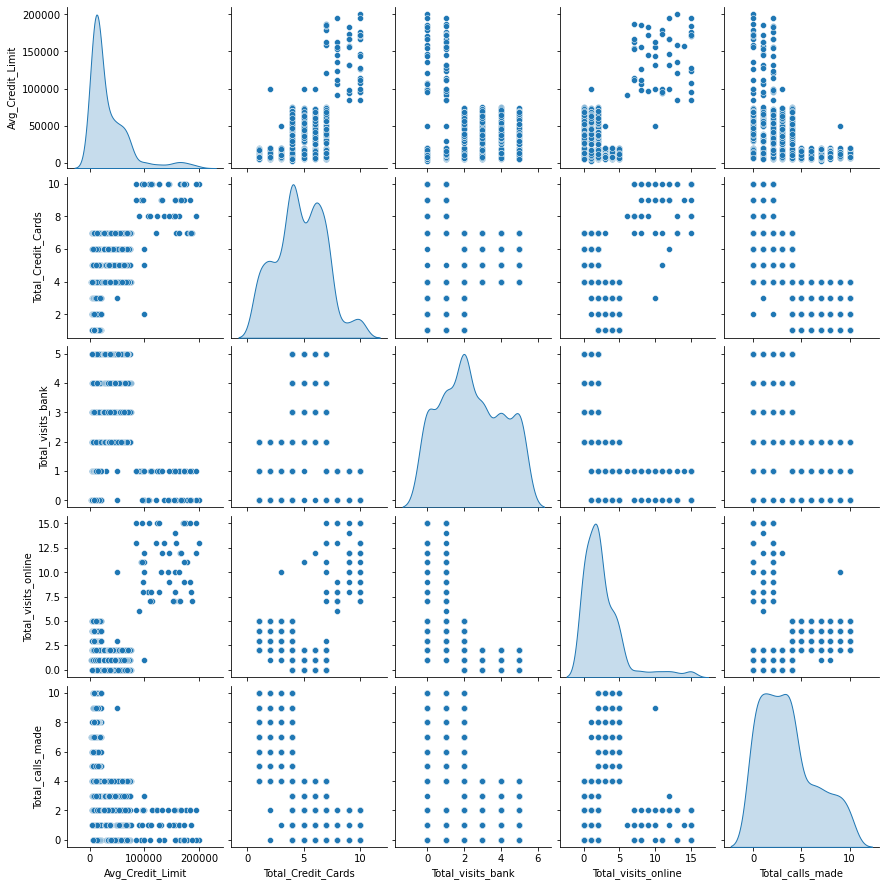

In [904]:
sns.pairplot(df,diag_kind='kde')

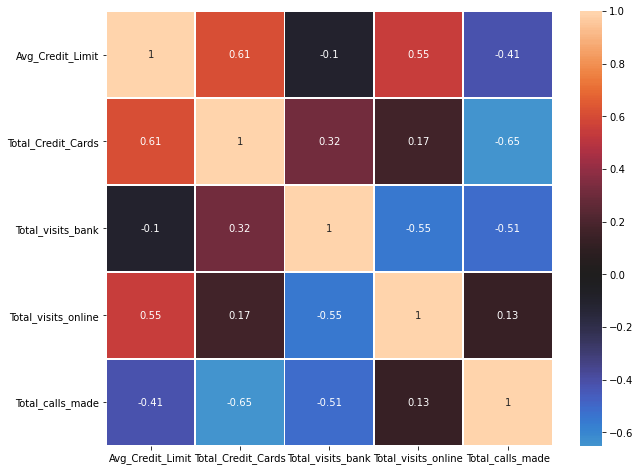

In [905]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0)
plt.show()

### Insight
- There is a stong relation between Average Credit Limit, Total credit cards and Total visits online.
- Almost not relation between Total calls made by the customers and the other features. Because there is not enough relation I will drop it.


In [940]:
df.drop(['Total_calls_made'], axis=1, inplace=True)
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online
0,100000,2,1,1
1,50000,3,0,10
2,50000,7,1,3
3,30000,5,1,1
4,100000,6,0,12


In [941]:
# Dataset has 11 (1.7%) duplicate rows and I droped
#df.drop_duplicates(inplace=True)

In [942]:
df.shape

(660, 4)

## K-means

<AxesSubplot:>

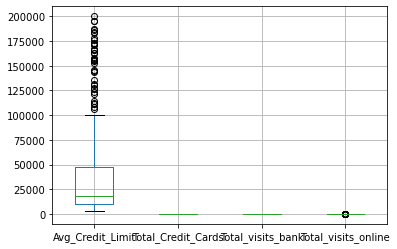

In [943]:
df.boxplot()

In [944]:
# Remove outliers base on zscore
from scipy.stats import zscore
df_new = df.apply(zscore)
df_new

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online
0,1.740187,-1.249225,-0.860451,-0.547490
1,0.410293,-0.787585,-1.473731,2.520519
2,0.410293,1.058973,-0.860451,0.134290
3,-0.121665,0.135694,-0.860451,-0.547490
4,1.740187,0.597334,-1.473731,3.202298
...,...,...,...,...
655,1.713589,2.443892,-0.860451,2.520519
656,1.314621,2.443892,-0.860451,3.543188
657,2.937092,1.520613,-0.860451,2.179629
658,3.655235,2.443892,-0.860451,4.224968


<AxesSubplot:>

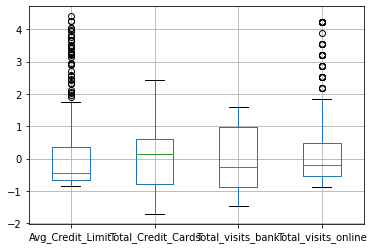

In [945]:
df_new.boxplot()

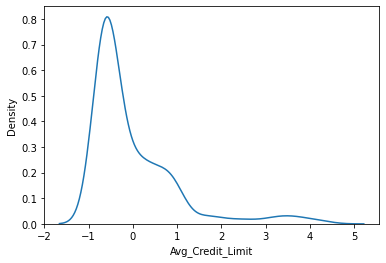

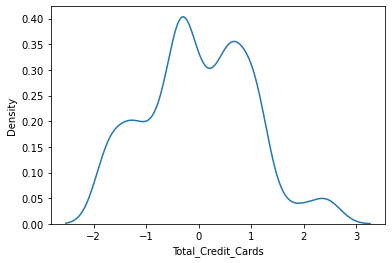

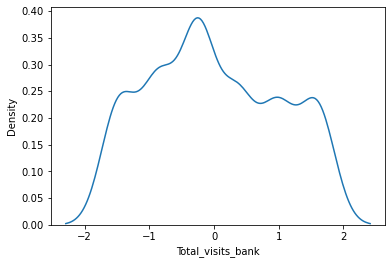

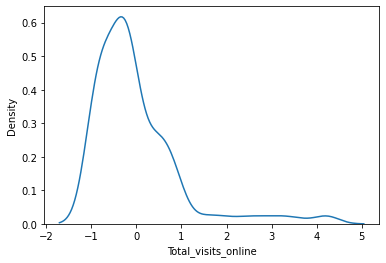

In [946]:
for i in df_new.columns:
    sns.distplot(df_new[i],hist=False,)
    plt.show()

### Insight
- Have been removed the outliers, but some outliers will remain.
- Because the Total_visit_online has an strong relation with Avg_Credit_Limit it will remain the outliers and see if there is a specific cluster with customers that prefer comunication e.g by email, or push notification.

In [947]:
cluster_range = range(1,10)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(df_new)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df[0:10]

,num_clusters,cluster_errors
0,1,2640.000000
1,2,1519.989708
2,3,720.856478
3,4,574.182788
4,5,511.212487
5,6,471.332831
6,7,424.367336
7,8,389.752222
8,9,366.794174


### Elbow Method

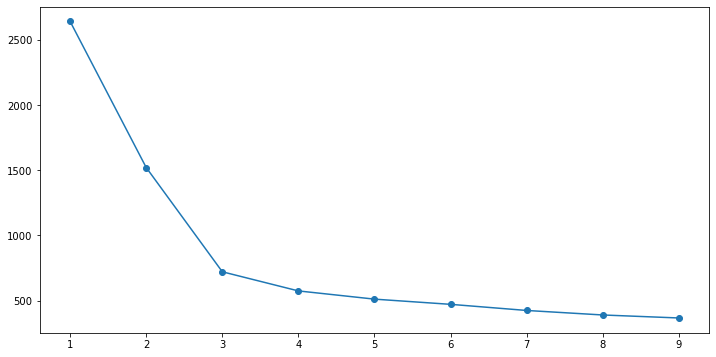

In [948]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [949]:
kmeans = KMeans( max_iter=100, n_clusters=3, n_init = 5, random_state=1)
kmeans.fit(df_new)

KMeans(max_iter=100, n_clusters=3, n_init=5, random_state=1)

In [950]:
label=kmeans.predict(df_new)
silhouette_score_k_means = silhouette_score(df_new, label)
silhouette_score_k_means

0.49069829816445293

In [951]:
centroids_k_means = kmeans.cluster_centers_
centroids_k_means

array([[-0.58119835, -1.03938858, -0.88699955,  0.30252126],
       [-0.01934402,  0.38782968,  0.68650404, -0.55738359],
       [ 2.83176409,  1.86222621, -1.10576269,  2.82731942]])

#### Centroid Dataframe

In [952]:
centroid_df = pd.DataFrame(centroids_k_means, columns = list(df_new) )
centroid_df.T

,0,1,2
Avg_Credit_Limit,-0.581198,-0.019344,2.831764
Total_Credit_Cards,-1.039389,0.387830,1.862226
Total_visits_bank,-0.887000,0.686504,-1.105763
Total_visits_online,0.302521,-0.557384,2.827319


In [953]:
labels = kmeans.labels_
counts = np.bincount(labels[labels>=0])
print(counts)

[231 379  50]


In [954]:
## creating a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')

In [955]:
df_labels.dtypes

labels    category
dtype: object

In [956]:
# Joining the label dataframe with the data frame.
df_new_labeled = df_new.join(df_labels)

In [957]:
df_new_labeled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,labels
0,1.740187,-1.249225,-0.860451,-0.547490,0
1,0.410293,-0.787585,-1.473731,2.520519,0
2,0.410293,1.058973,-0.860451,0.134290,1
3,-0.121665,0.135694,-0.860451,-0.547490,0
4,1.740187,0.597334,-1.473731,3.202298,2


In [958]:
df_new_labeled['labels'].value_counts()

1    379
0    231
2     50
Name: labels, dtype: int64

Text(0.5, 0.92, 'Data Visualization')

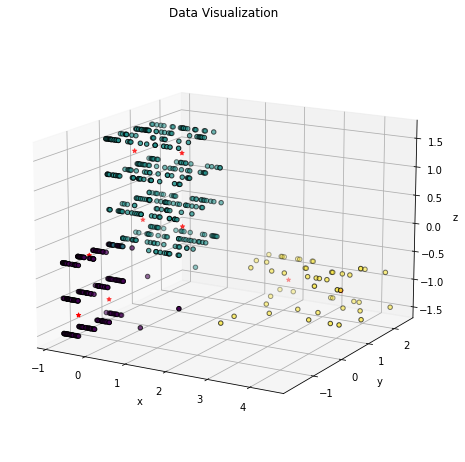

In [959]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=15)
ax.scatter(df_new_labeled.iloc[:, 0], df_new_labeled.iloc[:, 1], df_new_labeled.iloc[:, 2],c=labels.astype(np.float), edgecolor='k')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='r', marker='*', label='centroid')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Data Visualization')

array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[labels]'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

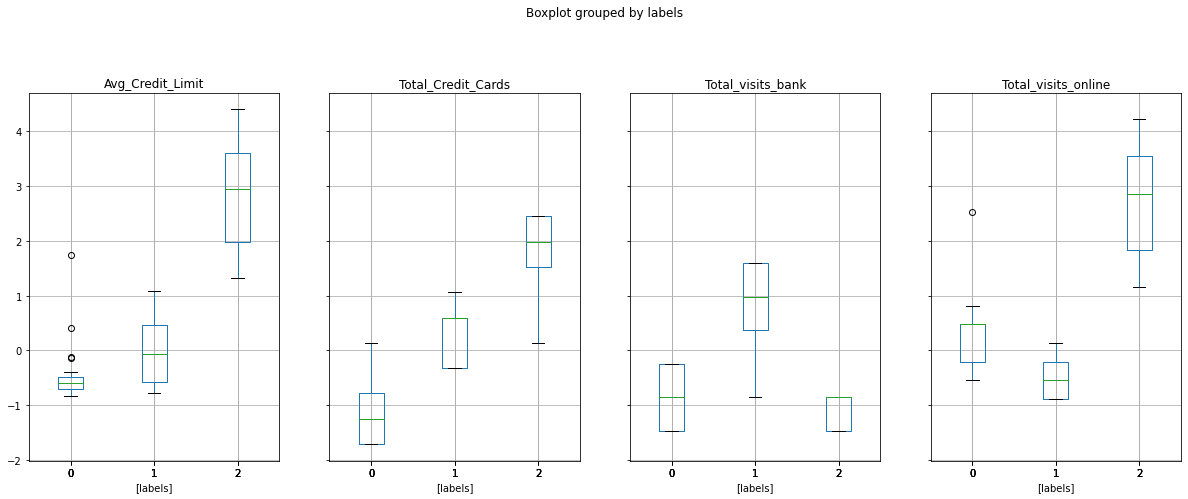

In [960]:
df_new_labeled.boxplot(by = 'labels',  layout=(2,4), figsize=(20, 15))

### Insight

#### In cluster 1
- It concentrate customers with credit limit close to 3000, they have less credit cards, as they also have lower visits to the bank. They are average online customers. 

#### In cluster 2
- It concentrate customers with credit limits close to the mean, as also the mean of credit card, they are less customers online, but they visit more the bank.

#### In cluster 3
- It concentrate customers with high credit limits, high number of credit card and lower visit to the bank but they are higher customers online


# Hierarchical Clustering

In [961]:
# linkages method average
ZA = linkage(df_new, metric='euclidean', method='average')
c, coph_dists = cophenet(ZA , pdist(df_new))
c

0.9029995575233576

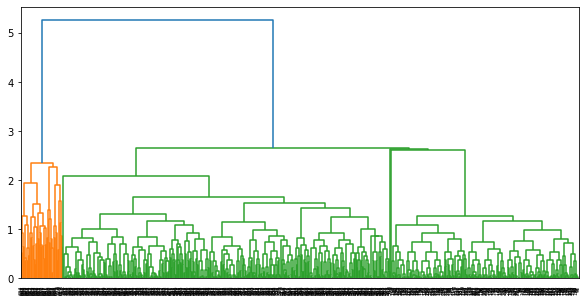

In [962]:
plt.figure(figsize=(10, 5))
dendrogram(ZA)
plt.show()

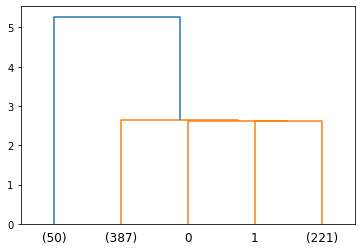

In [963]:
dendrogram(
    ZA,
    truncate_mode='lastp', 
    p=5, 
)
plt.show()

In [969]:
max_d = 3
clusters_A = fcluster(ZA, max_d, criterion='distance')
clusters_A

array([2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [970]:
silhouette_score_average = silhouette_score(df_new,clusters_A)
silhouette_score_average

0.624727672064764

In [971]:
df_labels = pd.DataFrame(clusters_A , columns = list(['clusters']))
df_labels['clusters'] = df_labels['clusters'].astype('category')

In [972]:
df_new_clusters_A = df_new.join(df_labels)
df_new_clusters_A.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,clusters
0,1.740187,-1.249225,-0.860451,-0.547490,2
1,0.410293,-0.787585,-1.473731,2.520519,2
2,0.410293,1.058973,-0.860451,0.134290,2
3,-0.121665,0.135694,-0.860451,-0.547490,2
4,1.740187,0.597334,-1.473731,3.202298,1


array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[clusters]'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

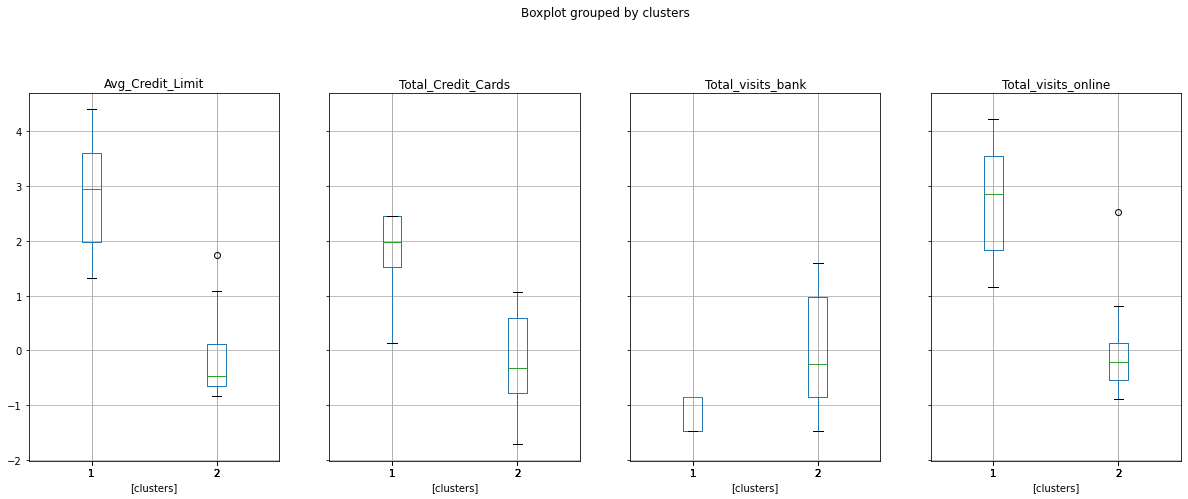

In [973]:
df_new_clusters_A.boxplot(by = 'clusters',  layout=(2,4), figsize=(20, 15))

### Insight

#### In cluster 1
- It concentrate customers with higher credit limi, have more credit cards, as they also have lower visits to the bank, but they are the most active online. 
 
#### In cluster 2
- It concentrate customers with credit limits close to the mean, also less credit card and more visit to the bank, and they are less customers online

### This two cluster are similar two cluster 1 and 2 for Kmeans


In [974]:
# linkages method complete
ZC = linkage(df_new, metric='euclidean', method='complete')
c, coph_dists = cophenet(ZC , pdist(df_new))
c

0.89034704041457

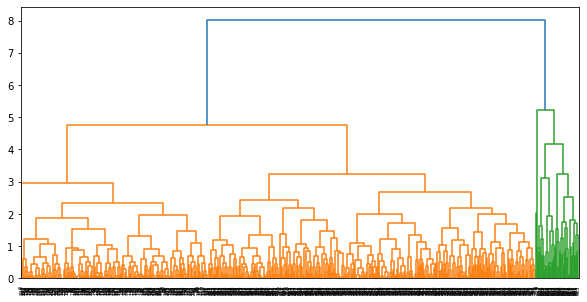

In [975]:
plt.figure(figsize=(10, 5))
dendrogram(ZC)
plt.show()

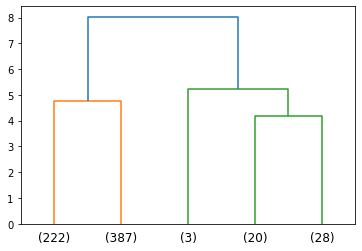

In [976]:
dendrogram(
    ZC,
    truncate_mode='lastp', 
    p=5, 
)
plt.show()

In [977]:
max_d = 5
clusters_C = fcluster(ZC, max_d, criterion='distance')
clusters_C

array([1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [997]:
silhouette_score_complete = silhouette_score(df_new,clusters_C)
silhouette_score_complete

0.497753751417808

In [982]:
df_labels = pd.DataFrame(clusters_C , columns = list(['clusters']))
df_labels['clusters'] = df_labels['clusters'].astype('category')

In [983]:
df_new_clusters_C = df_new.join(df_labels)
df_new_clusters_C.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,clusters
0,1.740187,-1.249225,-0.860451,-0.547490,1
1,0.410293,-0.787585,-1.473731,2.520519,2
2,0.410293,1.058973,-0.860451,0.134290,1
3,-0.121665,0.135694,-0.860451,-0.547490,1
4,1.740187,0.597334,-1.473731,3.202298,2


array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[clusters]'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

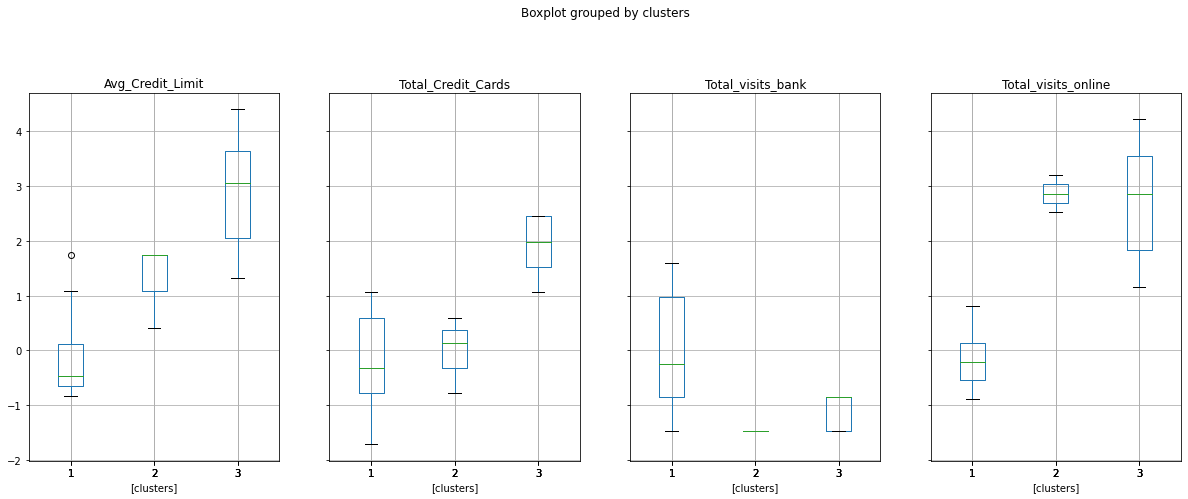

In [984]:
df_new_clusters_C.boxplot(by = 'clusters',  layout=(2,4), figsize=(20, 15))

### Insight


In [985]:
# linkages method ward
ZW = linkage(df_new, metric='euclidean', method='ward')
c, coph_dists = cophenet(ZW , pdist(df_new))
c

0.7690976045047357

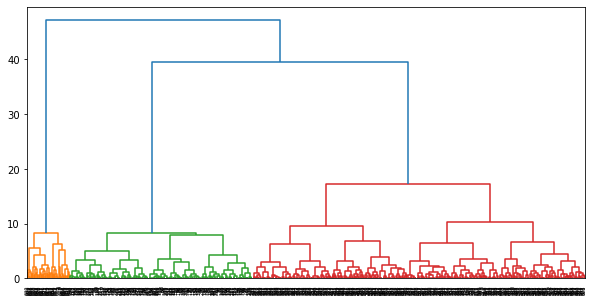

In [986]:
plt.figure(figsize=(10, 5))
dendrogram(ZW)
plt.show()

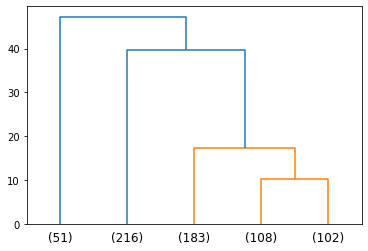

In [987]:
dendrogram(
    ZW,
    truncate_mode='lastp', 
    p=5, 
)
plt.show()

In [990]:
max_d = 35
clusters_W = fcluster(ZW, max_d, criterion='distance')
clusters_W

array([3, 1, 3, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [991]:
silhouette_score_ward = silhouette_score(df_new,clusters_W)
silhouette_score_ward

0.48595151547112686

In [992]:
df_labels = pd.DataFrame(clusters_W , columns = list(['clusters']))
df_labels['clusters'] = df_labels['clusters'].astype('category')

In [993]:
df_new_clusters_W = df_new.join(df_labels)
df_new_clusters_W.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,clusters
0,1.740187,-1.249225,-0.860451,-0.547490,3
1,0.410293,-0.787585,-1.473731,2.520519,1
2,0.410293,1.058973,-0.860451,0.134290,3
3,-0.121665,0.135694,-0.860451,-0.547490,3
4,1.740187,0.597334,-1.473731,3.202298,1


array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[clusters]'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

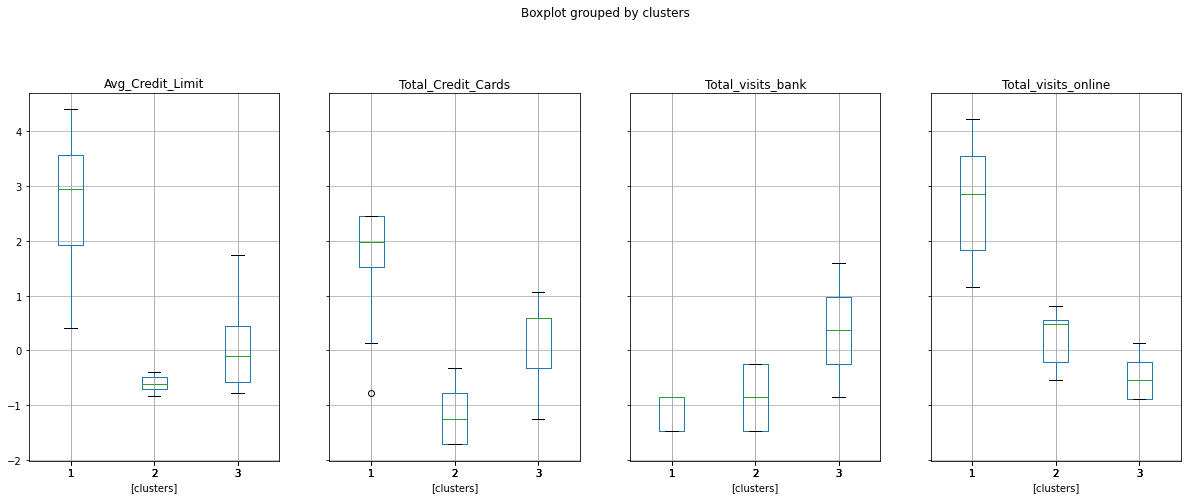

In [994]:
df_new_clusters_W.boxplot(by = 'clusters',  layout=(2,4), figsize=(20, 15))

### Insight

## Compare K-means clusters with Hierarchical clusters. 

In [996]:
grid = pd.DataFrame({'Method':['Kmeans', 'Hierarchical/average', 'Hierarchical/complete', 'Hierarchical/ward' ], 'silhouette_score': [silhouette_score_k_means, silhouette_score_average, silhouette_score_complete, silhouette_score_ward]})
grid = grid[['Method', 'silhouette_score']]
grid

,Method,silhouette_score
0,Kmeans,0.490698
1,Hierarchical/average,0.624728
2,Hierarchical/complete,0.497754
3,Hierarchical/ward,0.485952


Silhouette Score is better when closer 1 and worse when closer to -1. The difference between Kmeans and Hierarchical Clustering is almost the same for linkages method complete and ward, they are not completly separate it as we can see in the 3D data visualization, but he value 0,4 and 0,5 can also indicate it some values overlaping.

For Hierarchical Clustering linkages method average, the silhouette score are 0.62 which means that the cluster are dense and nicely separate. 

There are some overlaping wich means the customers are very similar and we can group it into a one and get a better value for silhouette score.

#### Based on this analysis one of the cluster need a digital comunication. For the other clusters the customers prefer to visit the bank and are candidates for creating a face-to-face comunication. 